# Where shall we sleep tonight?
## an unsupervised approach to Boston AirBnB accommodation

The dataset used in this work come from kaggle and is available at https://www.kaggle.com/airbnb/boston.
A blog capturing the analysis and its context can be found at https://bernardesite.wordpress.com/boston-airbnb/

<br>

The full dataset include three different tables:
  * listings.csv this table describes the accomodation and contains 95 variables
  * calendar.csv this table contains the availability for the next year and the price asked for each day
  * reviews.csv this table contains text-reviews related to the different accomodations

<br>
In this work,by applyinf unsupervised clustering, we will try to have a better understanding of the different areas in Boston, their price and the quality of their accomodation.


<a id='ToC' a> </a>
## Table of Content
  * [Librairies](#lib)
  * [Read the data in](#read)
  * [Data cleaning](#clean)
      * [Remove useless variables](#useless)
      * [Fixe data type](#type)
      * [Amenities](#amen)
      * [Variation of the price](#var)

      * [Outliers](#out)
  * [Clustering](#cluster)
    * [Mapping the accommodations](#map)
    * [DBSCAN](#DBSCAN)
    * [K Mean](#kmean)
    * [Final clustering](#final)
  * [Characterization](#char)
    * [Score of the reviews](#review)
    * [Price](#price)
    * [Changes during the year](#year)
    
  

<a id='lib'> </a>
## Librairies

[Top](#ToC)

In [36]:
print('versions used:')
import sys
print('python: {}'.format(sys.version[:6]))

import pandas as pd
print('pandas: {}'.format(pd.__version__))

import numpy as np
print('numpy: {}'.format(np.__version__))

import matplotlib.pyplot as plt
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
del matplotlib #free some memory

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import sklearn
print('scikit learn: {}'.format(sklearn.__version__))
del sklearn #free some memory

import seaborn as sns
print('seaborn: {}'.format(sns.__version__))


versions used:
python: 3.6.3 
pandas: 0.23.3
numpy: 1.12.1
matplotlib: 2.1.0
scikit learn: 0.19.1
seaborn: 0.8.1


<a id='read'> </a>
## Read the data in

[Top](#ToC)

In [37]:
df= pd.read_csv('listings.csv')
display(df.sample(3))
print('size of the dataset:{}'.format(df.shape))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1788,8696236,https://www.airbnb.com/rooms/8696236,20160906204935,2016-09-07,Private Room in Downtown Boston MGH,"Within steps of Mass General Hospital, TD Gard...",You will be staying in your own large private ...,"Within steps of Mass General Hospital, TD Gard...",none,"Wonderful parks, restaurants, and museums are ...",...,9.0,f,NaN,NaN,t,moderate,f,f,2,3.56
1221,6075932,https://www.airbnb.com/rooms/6075932,20160906204935,2016-09-07,South End Charm- Private Bed/Bath,"This charming ""private room"" is really an enti...",Our space is very charming and will fit 2 peop...,"This charming ""private room"" is really an enti...",none,Located in the heart of the historic South End...,...,10.0,f,NaN,NaN,f,strict,f,f,1,1.80
763,11223924,https://www.airbnb.com/rooms/11223924,20160906204935,2016-09-07,North End 1 BR Gem in Little Italy,Newly renovated 1 Bedroom | 1 Bath located in ...,- Just renovated 1 bedroom / 1 bathroom plus a...,Newly renovated 1 Bedroom | 1 Bath located in ...,none,NaN,...,10.0,f,NaN,NaN,t,strict,f,f,15,4.59


size of the dataset:(3585, 95)


In [38]:
df2 = pd.read_csv('calendar.csv')
display(df2.sample(3))
print('size of the dataset:{}'.format(df2.shape))

,listing_id,date,available,price
1042431,12366845,2016-09-14,f,NaN
353738,8686165,2017-05-13,f,NaN
1044838,7842550,2017-02-09,f,NaN


size of the dataset:(1308890, 4)


<a id='clean'> </a>
## Data cleaning


<a id='useless'> </a>


   * **Remove useless variables**
   
   * [Fixe data type](#type)
   * [Amenities](#amen)
   * [Variation of the price](#var)

   * [Outliers](#out)

[Top](#ToC)

Some variables do not seems very useful for our purpose

In [39]:
droplist=[ 'listing_url', 'scrape_id',  'name', 'summary', 'host_id','host_listings_count',
       'host_total_listings_count', 'space', 'description','neighborhood_overview', 'host_location',
       'notes', 'transit', 'access', 'interaction', 'house_rules','host_has_profile_pic','require_guest_profile_picture',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url','host_url', 'host_name','host_about',
       'host_thumbnail_url', 'host_picture_url','street','neighbourhood', 'market','instant_bookable', 
       'cancellation_policy', 'require_guest_phone_verification', 'host_verifications',
       'calculated_host_listings_count', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
       'square_feet',# only populated for less than 10%
         ]
df.drop(droplist, axis=1, inplace=True)

Variables with only one value are unlikely to be usefull

In [40]:
one_val=[]
for col in df.columns:
    display(df[col].head())
    diffval=len(df[col].unique())
    if diffval==1:
        one_val+=[col]
one_val.remove('last_scraped')#This variable will be used later in the analysis
df.drop(one_val, axis=1, inplace=True)

0    12147973
1     3075044
2        6976
3     1436513
4     7651065
Name: id, dtype: int64

0    2016-09-07
1    2016-09-07
2    2016-09-07
3    2016-09-07
4    2016-09-07
Name: last_scraped, dtype: object

0    none
1    none
2    none
3    none
4    none
Name: experiences_offered, dtype: object

0    2015-04-15
1    2012-06-07
2    2009-05-11
3    2013-04-21
4    2014-05-11
Name: host_since, dtype: object

0                   NaN
1        within an hour
2    within a few hours
3    within a few hours
4        within an hour
Name: host_response_time, dtype: object

0     NaN
1    100%
2    100%
3    100%
4    100%
Name: host_response_rate, dtype: object

0     NaN
1    100%
2     88%
3     50%
4    100%
Name: host_acceptance_rate, dtype: object

0    f
1    f
2    t
3    f
4    t
Name: host_is_superhost, dtype: object

0    Roslindale
1    Roslindale
2    Roslindale
3           NaN
4    Roslindale
Name: host_neighbourhood, dtype: object

0    f
1    t
2    t
3    f
4    t
Name: host_identity_verified, dtype: object

0    Roslindale
1    Roslindale
2    Roslindale
3    Roslindale
4    Roslindale
Name: neighbourhood_cleansed, dtype: object

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: neighbourhood_group_cleansed, dtype: float64

0    Boston
1    Boston
2    Boston
3    Boston
4    Boston
Name: city, dtype: object

0    MA
1    MA
2    MA
3    MA
4    MA
Name: state, dtype: object

0    02131
1    02131
2    02131
3      NaN
4    02131
Name: zipcode, dtype: object

0    Boston, MA
1    Boston, MA
2    Boston, MA
3    Boston, MA
4    Boston, MA
Name: smart_location, dtype: object

0    US
1    US
2    US
3    US
4    US
Name: country_code, dtype: object

0    United States
1    United States
2    United States
3    United States
4    United States
Name: country, dtype: object

0    42.282619
1    42.286241
2    42.292438
3    42.281106
4    42.284512
Name: latitude, dtype: float64

0   -71.133068
1   -71.134374
2   -71.135765
3   -71.121021
4   -71.136258
Name: longitude, dtype: float64

0    t
1    t
2    t
3    f
4    t
Name: is_location_exact, dtype: object

0        House
1    Apartment
2    Apartment
3        House
4        House
Name: property_type, dtype: object

0    Entire home/apt
1       Private room
2       Private room
3       Private room
4       Private room
Name: room_type, dtype: object

0    4
1    2
2    2
3    4
4    2
Name: accommodates, dtype: int64

0    1.5
1    1.0
2    1.0
3    1.0
4    1.5
Name: bathrooms, dtype: float64

0    2.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: bedrooms, dtype: float64

0    3.0
1    1.0
2    1.0
3    2.0
4    2.0
Name: beds, dtype: float64

0    Real Bed
1    Real Bed
2    Real Bed
3    Real Bed
4    Real Bed
Name: bed_type, dtype: object

0    {TV,"Wireless Internet",Kitchen,"Free Parking ...
1    {TV,Internet,"Wireless Internet","Air Conditio...
2    {TV,"Cable TV","Wireless Internet","Air Condit...
3    {TV,Internet,"Wireless Internet","Air Conditio...
4    {Internet,"Wireless Internet","Air Conditionin...
Name: amenities, dtype: object

0    $250.00
1     $65.00
2     $65.00
3     $75.00
4     $79.00
Name: price, dtype: object

0        NaN
1    $400.00
2    $395.00
3        NaN
4        NaN
Name: weekly_price, dtype: object

0          NaN
1          NaN
2    $1,350.00
3          NaN
4          NaN
Name: monthly_price, dtype: object

0        NaN
1     $95.00
2        NaN
3    $100.00
4        NaN
Name: security_deposit, dtype: object

0    $35.00
1    $10.00
2       NaN
3    $50.00
4    $15.00
Name: cleaning_fee, dtype: object

0    1
1    0
2    1
3    2
4    1
Name: guests_included, dtype: int64

0     $0.00
1     $0.00
2    $20.00
3    $25.00
4     $0.00
Name: extra_people, dtype: object

0    2
1    2
2    3
3    1
4    2
Name: minimum_nights, dtype: int64

0    1125
1      15
2      45
3    1125
4      31
Name: maximum_nights, dtype: int64

0    2 weeks ago
1     a week ago
2     5 days ago
3     a week ago
4    2 weeks ago
Name: calendar_updated, dtype: object

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: has_availability, dtype: float64

0    2016-09-06
1    2016-09-06
2    2016-09-06
3    2016-09-06
4    2016-09-06
Name: calendar_last_scraped, dtype: object

0     0
1    36
2    41
3     1
4    29
Name: number_of_reviews, dtype: int64

0           NaN
1    2014-06-01
2    2009-07-19
3    2016-08-28
4    2015-08-18
Name: first_review, dtype: object

0           NaN
1    2016-08-13
2    2016-08-05
3    2016-08-28
4    2016-09-01
Name: last_review, dtype: object

0      NaN
1     94.0
2     98.0
3    100.0
4     99.0
Name: review_scores_rating, dtype: float64

0     NaN
1    10.0
2    10.0
3    10.0
4    10.0
Name: review_scores_accuracy, dtype: float64

0     NaN
1     9.0
2     9.0
3    10.0
4    10.0
Name: review_scores_cleanliness, dtype: float64

0     NaN
1    10.0
2    10.0
3    10.0
4    10.0
Name: review_scores_checkin, dtype: float64

0     NaN
1    10.0
2    10.0
3    10.0
4    10.0
Name: review_scores_communication, dtype: float64

0     NaN
1     9.0
2     9.0
3    10.0
4     9.0
Name: review_scores_location, dtype: float64

0     NaN
1     9.0
2    10.0
3    10.0
4    10.0
Name: review_scores_value, dtype: float64

0    f
1    f
2    f
3    f
4    f
Name: requires_license, dtype: object

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: license, dtype: float64

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: jurisdiction_names, dtype: float64

0     NaN
1    1.30
2    0.47
3    1.00
4    2.25
Name: reviews_per_month, dtype: float64

In [41]:
for col in df.columns:
    display(df[col].sample(5))
    diffval=len(df[col].unique())
    print(diffval, 'different values')

687     14624254
2090     4190704
1171     1428355
2921     9494511
3519    14572086
Name: id, dtype: int64

3585 different values


2454    2016-09-07
1686    2016-09-07
2748    2016-09-07
3571    2016-09-07
1281    2016-09-07
Name: last_scraped, dtype: object

1 different values


2994    2015-01-13
1254    2009-07-10
3370    2016-06-07
2505    2015-12-06
3172    2011-07-01
Name: host_since, dtype: object

1281 different values


1174        within an hour
1837                   NaN
1218          within a day
761                    NaN
1011    within a few hours
Name: host_response_time, dtype: object

5 different values


565      96%
1027     NaN
156      50%
1063    100%
2998    100%
Name: host_response_rate, dtype: object

53 different values


128     100%
2873     70%
3326     NaN
1260     45%
20       94%
Name: host_acceptance_rate, dtype: object

73 different values


2570    f
2555    f
2152    f
2104    f
397     f
Name: host_is_superhost, dtype: object

2 different values


2430               NaN
1635    Fenway/Kenmore
1665       East Boston
949        Gay Village
2100       Beacon Hill
Name: host_neighbourhood, dtype: object

54 different values


2220    t
2561    t
2420    t
3067    t
1225    t
Name: host_identity_verified, dtype: object

2 different values


3109    South Boston Waterfront
1715                Charlestown
347               Jamaica Plain
2424                     Fenway
1167                  South End
Name: neighbourhood_cleansed, dtype: object

25 different values


1350    Boston
661     Boston
870     Boston
204     Boston
3260    Boston
Name: city, dtype: object

39 different values


81      02130
3184    02127
2279    02215
3315    02134
718     02109
Name: zipcode, dtype: object

44 different values


2566    Boston, MA
2287    Boston, MA
1955    Boston, MA
3152    Boston, MA
153     Boston, MA
Name: smart_location, dtype: object

39 different values


313     42.306410
1635    42.365112
1601    42.369595
1906    42.358505
518     42.334549
Name: latitude, dtype: float64

3585 different values


2793   -71.059791
612    -71.062907
607    -71.060129
1866   -71.068263
1237   -71.075397
Name: longitude, dtype: float64

3585 different values


1073    t
581     t
306     t
2471    t
2543    t
Name: is_location_exact, dtype: object

2 different values


3196        House
2861        House
3287    Apartment
3046    Apartment
1022        House
Name: property_type, dtype: object

14 different values


1005    Entire home/apt
2480    Entire home/apt
2234    Entire home/apt
1353    Entire home/apt
1423    Entire home/apt
Name: room_type, dtype: object

3 different values


3491    2
926     4
1128    4
2408    4
234     6
Name: accommodates, dtype: int64

14 different values


2620    1.0
360     1.0
3552    1.0
2000    1.0
935     1.0
Name: bathrooms, dtype: float64

13 different values


2062    1.0
2277    1.0
2492    1.0
2059    1.0
2627    1.0
Name: bedrooms, dtype: float64

7 different values


479     3.0
1715    1.0
3513    3.0
2905    1.0
2306    2.0
Name: beds, dtype: float64

12 different values


3375    Real Bed
3501    Real Bed
2628    Real Bed
2583    Real Bed
25      Real Bed
Name: bed_type, dtype: object

5 different values


2261    {Internet,"Wireless Internet",Kitchen,"Pets Al...
3426    {TV,Internet,"Wireless Internet",Kitchen,"Pets...
24      {TV,"Cable TV",Internet,"Wireless Internet","A...
2686    {"Wireless Internet","Air Conditioning",Kitche...
3136    {TV,"Cable TV",Internet,"Wireless Internet","A...
Name: amenities, dtype: object

3092 different values


1423    $159.00
1355    $464.00
638     $180.00
2393    $150.00
555     $399.00
Name: price, dtype: object

324 different values


2507    NaN
648     NaN
1488    NaN
2026    NaN
805     NaN
Name: weekly_price, dtype: object

244 different values


3325          NaN
467           NaN
2244    $6,270.00
886           NaN
2476          NaN
Name: monthly_price, dtype: object

289 different values


568     $250.00
1313        NaN
2697    $100.00
1845    $100.00
2221        NaN
Name: security_deposit, dtype: object

55 different values


1023     $65.00
2742        NaN
2461    $100.00
1042    $225.00
1210        NaN
Name: cleaning_fee, dtype: object

80 different values


2502    1
1453    2
1908    1
1450    1
2252    1
Name: guests_included, dtype: int64

13 different values


655      $0.00
3450     $0.00
289      $0.00
2384     $0.00
541     $45.00
Name: extra_people, dtype: object

51 different values


1645    3
3150    1
1850    5
2887    2
1878    4
Name: minimum_nights, dtype: int64

29 different values


1167    1125
1029    1125
861     1125
191       10
2926      60
Name: maximum_nights, dtype: int64

85 different values


41      3 weeks ago
2424     a week ago
3034    2 weeks ago
1919     2 days ago
3481    2 weeks ago
Name: calendar_updated, dtype: object

38 different values


1039    78
262     41
2781     6
1034     2
139      9
Name: number_of_reviews, dtype: int64

178 different values


2137    2015-05-08
2498           NaN
3489    2015-09-01
2990    2016-05-13
399            NaN
Name: first_review, dtype: object

976 different values


3558           NaN
1087    2016-08-28
241     2016-08-30
2464           NaN
2847    2016-09-05
Name: last_review, dtype: object

405 different values


2161      NaN
3423     93.0
2915     99.0
2035    100.0
921      80.0
Name: review_scores_rating, dtype: float64

49 different values


742     10.0
3488     NaN
2500     NaN
2539     9.0
515     10.0
Name: review_scores_accuracy, dtype: float64

9 different values


2270    10.0
1149    10.0
803     10.0
540     10.0
2464     NaN
Name: review_scores_cleanliness, dtype: float64

10 different values


2620    10.0
2086     NaN
1575     NaN
1457    10.0
250      9.0
Name: review_scores_checkin, dtype: float64

9 different values


1543     9.0
524     10.0
472     10.0
3359     NaN
1702     8.0
Name: review_scores_communication, dtype: float64

8 different values


665     10.0
1891     NaN
3439    10.0
1093    10.0
3248     9.0
Name: review_scores_location, dtype: float64

10 different values


2413     NaN
1049     NaN
263     10.0
2448     NaN
2813    10.0
Name: review_scores_value, dtype: float64

10 different values


1990    2.31
3057     NaN
3129    0.90
1640    4.07
116     2.81
Name: reviews_per_month, dtype: float64

645 different values


<a id='type'> </a>
##    Data cleaning
<br>

   * [Remove useless variables](#useless)
   
   *  **Fixe data type**
   * [Amenities](#amen)
   * [Variation of the price](#var)

   * [Outliers](#out)

[Top](#ToC)

Dealing with date variable and creating a new variable

In [42]:
list_date=['last_scraped', 'host_since','first_review', 'last_review']
for var in list_date:
    df[var]=pd.to_datetime(df[var])

df['number_of_days']=(df.last_scraped-df.host_since).dt.days
df['days_since_last_review']=(df.last_scraped-df.last_review).dt.days

df['days_between_reviews']=df['number_of_days']/df.number_of_reviews
df.days_between_reviews.replace(np.inf,-1, inplace=True)
df['reviews_per_month']=df.reviews_per_month.replace(np.nan, 0) #missing value are in fact property without review

Dealing with boolean variable

In [43]:
binvar=['host_identity_verified','host_is_superhost', 'is_location_exact',  ]
for var in binvar:
    df[var]=[0 if x=='f' else 1 for x in df[var]]

<a id='amen'> </a>
##    Data cleaning
<br>

   * [Remove useless variables](#useless)
   
   * [Fixe data type](#type)
   * **Amenities**
   * [Variation of the price](#var)
   * [Outliers](#out)

[Top](#ToC)

Counting the number of amenities and listing them

In [44]:
dict_amenities={}
num_amenties=[]
for ensemble in df.amenities.tolist():
    ensemble_list=ensemble[1:-1].split(',')
    num_amenties+=[len(ensemble_list)]
    for elem in ensemble_list:
        elem=elem.replace('"', '')
        try:
            dict_amenities[elem] += 1
        except:
            dict_amenities[elem]=1
df['num_amenities']=num_amenties

In [45]:
print('Count for each amenity:\n-----------------------')
for k,v in dict_amenities.items():
    print(k,':', v)

Count for each amenity:
-----------------------
TV : 2607
Wireless Internet : 3421
Kitchen : 3284
Free Parking on Premises : 831
Pets live on this property : 429
Dog(s) : 229
Heating : 3384
Family/Kid Friendly : 1888
Washer : 2475
Dryer : 2476
Smoke Detector : 2911
Fire Extinguisher : 1582
Essentials : 2994
Shampoo : 2421
Laptop Friendly Workspace : 1834
Internet : 2577
Air Conditioning : 2821
Pets Allowed : 486
Carbon Monoxide Detector : 2442
Lock on Bedroom Door : 474
Hangers : 1985
Hair Dryer : 1811
Iron : 1828
Cable TV : 1770
First Aid Kit : 1063
Safety Card : 458
translation missing: en.hosting_amenity_49 : 444
translation missing: en.hosting_amenity_50 : 581
Gym : 479
Breakfast : 316
Indoor Fireplace : 393
Cat(s) : 181
24-Hour Check-in : 1247
Hot Tub : 167
Buzzer/Wireless Intercom : 839
Other pet(s) : 16
Washer / Dryer : 2
Smoking Allowed : 95
 : 32
Suitable for Events : 138
Wheelchair Accessible : 148
Elevator in Building : 868
Pool : 160
Doorman : 268
Paid Parking Off Premises 

<a id='var'> </a>
##    Data cleaning
<br>

   * [Remove useless variables](#useless)
   
   * [Fixe data type](#type)
   * [Amenities](#amen)
   * **Variation of the price**
   * [Outliers](#out)

[Top](#ToC)

Creating different versions for the price

In [46]:
#First converting the price into a numeric variable
df['price_num']=[float(x[1:].replace(',',''))for x in df.price]

df['beds']=df.beds.replace(np.nan,1 )
df['beds']=df.beds.replace(0,1 )
df['bedrooms']=df.bedrooms.replace(np.nan,1 )
df['bedrooms']=df.bedrooms.replace(0,1 )
df['price_per_extrapeople']=[int(x[1:-3])for x in df.extra_people]

df['price_per_bedroom']=df['price_num']/df.bedrooms
df['price_per_bed']=df['price_num']/df.beds
df['price_per_person']=df['price_num']/df.accommodates


df['full_price']=df.price_num+(df.accommodates-df.guests_included)*df.price_per_extrapeople
df['full_price_per_person']=df['full_price']/df.accommodates

<a id='out'> </a>
##    Data cleaning
<br>

   * [Remove useless variables](#useless)
   
   * [Fixe data type](#type)
   * [Amenities](#amen)
   * [Variation of the price](#var)
   * **Outliers**

[Top](#ToC)

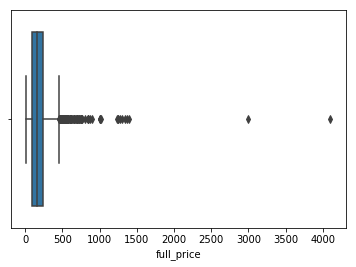

In [47]:
#identifying outlier
sns.boxplot(x='full_price', data=df)
plt.show()

Removing accomodation with price higher than 2k

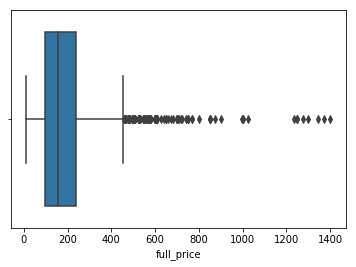

In [48]:
df=df[df.price_num<2000]
sns.boxplot(x='full_price', data=df)
plt.show()

<a id='cluster'> </a>
## Clustering

<a id='map'> </a>

<br>

   * **Mapping the accommodations**
   * [DBSCAN](#DBSCAN)
   * [K Mean](#kmean)
   * [Final clustering](#final)
   
[Top](#ToC)

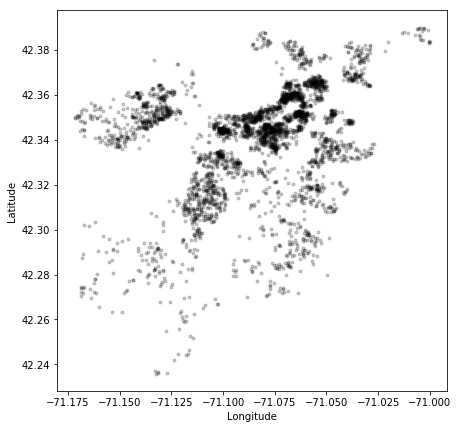

In [49]:
#use the latitude and longitude variable to plot a map of Boston
plt.figure(figsize=(7,7))
plt.plot(df.longitude, df.latitude, '.', alpha=0.2,c='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Plotting different locations in order to give some landmarks

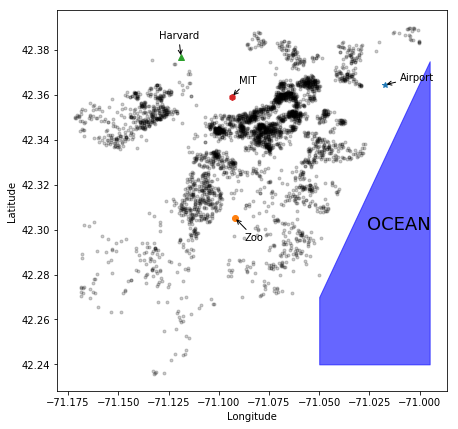

In [50]:
plt.figure(figsize=(7,7))
plt.plot(df.longitude, df.latitude, '.', alpha=0.2,c='k')
plt.plot(-71.017439, 42.3645004,'*')#airpot
plt.annotate( 'Airport',xy=( -71.017439, 42.3645004),xytext=(-71.01, 42.3665),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.0920313,42.3052659, 'o')#zoo
plt.annotate( 'Zoo',xy=( -71.0920313,42.3052659),xytext=(-71.087, 42.295),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.118789,42.3767973,'^') #harvard
plt.annotate( 'Harvard',xy=(-71.118789,42.3767973),xytext=(-71.13, 42.385),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.0934982,42.3592003,'h')#MIT
plt.annotate( 'MIT',xy=(-71.0934982,42.3592003),xytext=(-71.09, 42.365),arrowprops=dict(arrowstyle='->'))
plt.annotate( 'OCEAN',xy=(-71.026,42.3), fontsize=18)
#plt.plot([-71.065,-70.995],[42.27,42.375], 'b', alpha=0.6)
plt.fill_between([-71.05,-70.995],[42.27,42.375],[42.24,42.24], color='b', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<a id='DBSCAN'> </a>
## Clustering
<br>

   * [Mapping the accommodations](#map)
   * **DBSCAN**
   * [K Mean](#kmean)
   * [Final clustering](#final)
   
[Top](#ToC)

Creating some clusters based on the location

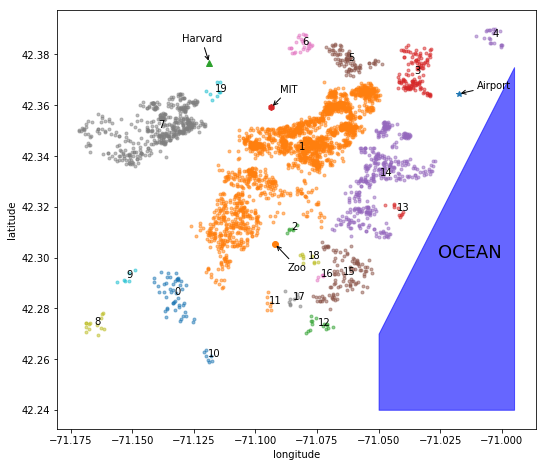

In [51]:
#This version is for adjusting the parameter of DBSCAN
clustering=DBSCAN()
clustering.eps=0.004 # size of the neighborhood
clustering.min_samples=5 #number of neighbors
df['a']=clustering.fit_predict(df[['latitude', 'longitude']])

long=df.longitude.max()-df.longitude.min()
lat=df.latitude.max()-df.latitude.min()
plt.figure(figsize=(long*50,lat*50))
for i in df.a.unique():
    if i>-1:
        plt.plot(df[df.a==i].longitude, df[df.a==i].latitude, '.', alpha=0.5)
        plt.annotate( str(i),xy=(df[df.a==i].longitude.mean(), df[df.a==i].latitude.mean()))

plt.plot(-71.017439, 42.3645004,'*')#airport
plt.annotate( 'Airport',xy=( -71.017439, 42.3645004),xytext=(-71.01, 42.3665),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.0920313,42.3052659, 'o')#zoo
plt.annotate( 'Zoo',xy=( -71.0920313,42.3052659),xytext=(-71.087, 42.295),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.118789,42.3767973,'^') #harvard
plt.annotate( 'Harvard',xy=(-71.118789,42.3767973),xytext=(-71.13, 42.385),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.0934982,42.3592003,'h')#MIT
plt.annotate( 'MIT',xy=(-71.0934982,42.3592003),xytext=(-71.09, 42.365),arrowprops=dict(arrowstyle='->'))
plt.annotate( 'OCEAN',xy=(-71.026,42.3), fontsize=18)
#plt.plot([-71.065,-70.995],[42.27,42.375], 'b', alpha=0.6)
plt.fill_between([-71.05,-70.995],[42.27,42.375],[42.24,42.24], color='b', alpha=0.6)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

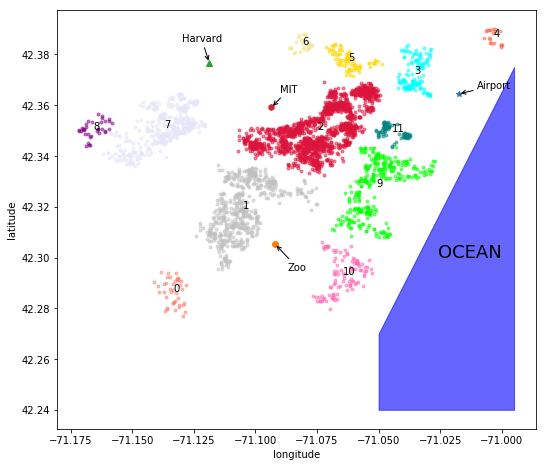

In [52]:
clustering=DBSCAN()
clustering.eps=0.004
clustering.min_samples=10
df['a']=clustering.fit_predict(df[['latitude', 'longitude']])
colist=['Salmon', 'Silver', 'Crimson','Aqua', 'Tomato', 'Gold', 'Khaki','Lavender',  'Purple', 'Lime','HotPink', 'Teal', 'DarkOliveGreen', 'SteelBlue', 'SandyBrown', 'Maroon' ]

long=df.longitude.max()-df.longitude.min()
lat=df.latitude.max()-df.latitude.min()
plt.figure(figsize=(long*50,lat*50))
for i in df.a.unique():
    if i>-1:
        plt.plot(df[df.a==i].longitude, df[df.a==i].latitude, '.', c=colist[int(i)],alpha=0.5)
        plt.annotate( str(i),xy=(df[df.a==i].longitude.mean(), df[df.a==i].latitude.mean()))

plt.plot(-71.017439, 42.3645004,'*')#airport
plt.annotate( 'Airport',xy=( -71.017439, 42.3645004),xytext=(-71.01, 42.3665),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.0920313,42.3052659, 'o')#zoo
plt.annotate( 'Zoo',xy=( -71.0920313,42.3052659),xytext=(-71.087, 42.295),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.118789,42.3767973,'^') #harvard
plt.annotate( 'Harvard',xy=(-71.118789,42.3767973),xytext=(-71.13, 42.385),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.0934982,42.3592003,'h')#MIT
plt.annotate( 'MIT',xy=(-71.0934982,42.3592003),xytext=(-71.09, 42.365),arrowprops=dict(arrowstyle='->'))
plt.annotate( 'OCEAN',xy=(-71.026,42.3), fontsize=18)

plt.fill_between([-71.05,-70.995],[42.27,42.375],[42.24,42.24], color='b', alpha=0.6)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

In [53]:
pct_left=df[df.a==-1].shape[0]/df.shape[0]
print('Percentage of accomodations not captured by a cluster : {}%'.format (round(100*pct_left,2)))

Percentage of accomodations not captured by a cluster : 6.84%


<a id='kmean'> </a>
## Clustering
<br>

   * [Mapping the accommodations](#map)
   * [DBSCAN](#DBSCAN)
   * **K Mean**
   * [Final clustering](#final)
   
[Top](#ToC)

Clustering the left over

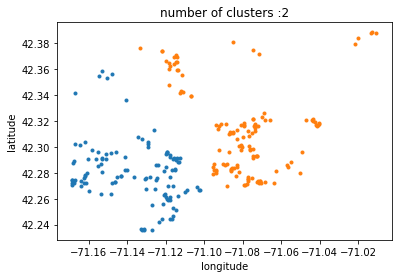

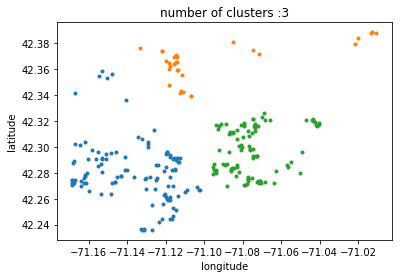

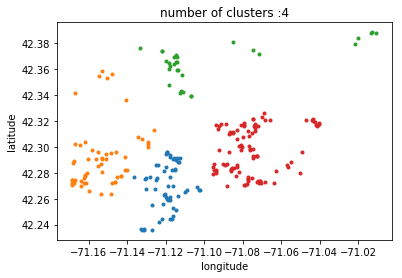

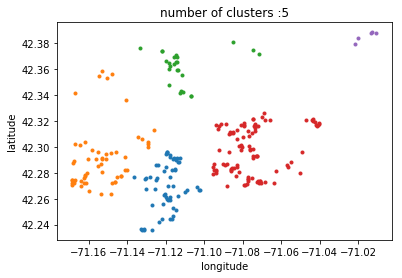

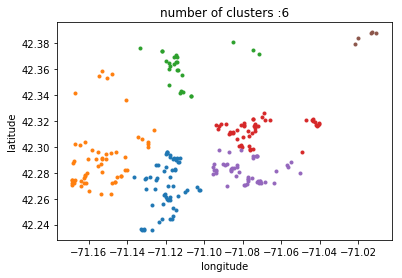

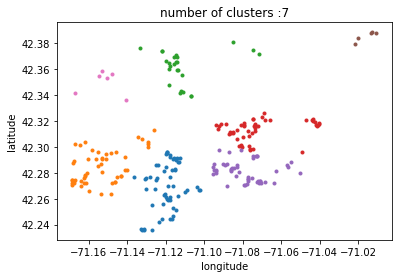

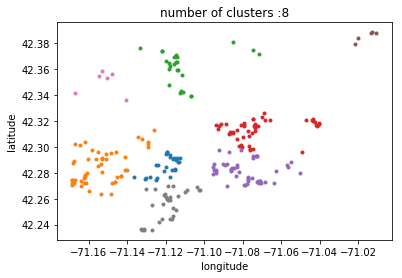

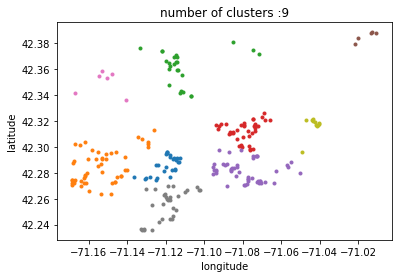

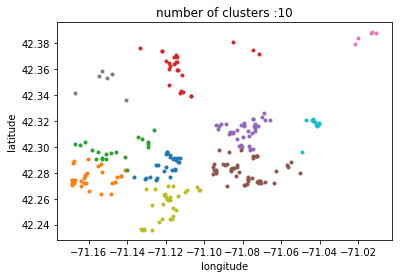

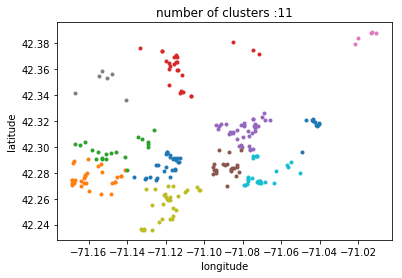

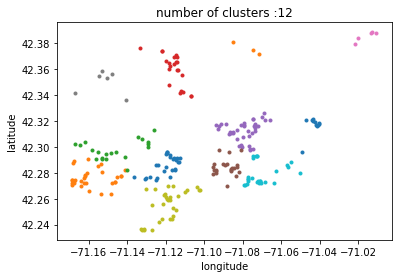

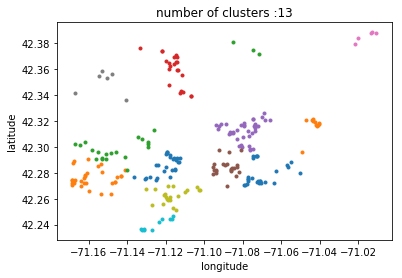

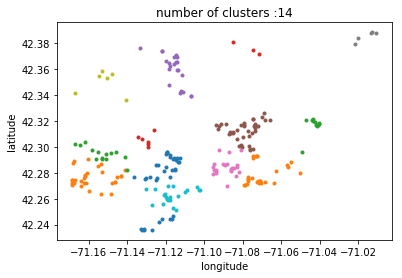

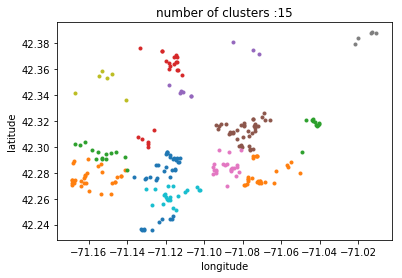

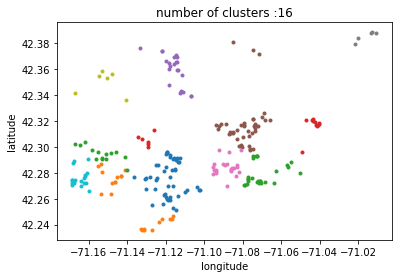

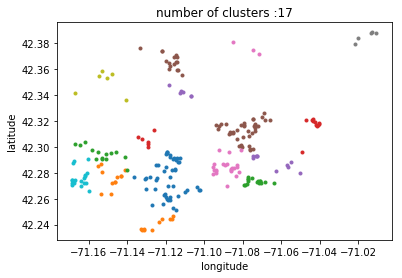

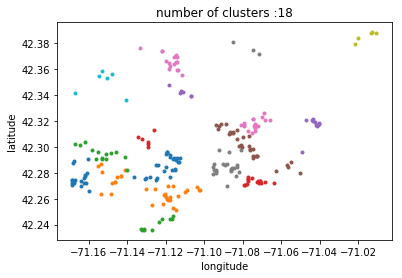

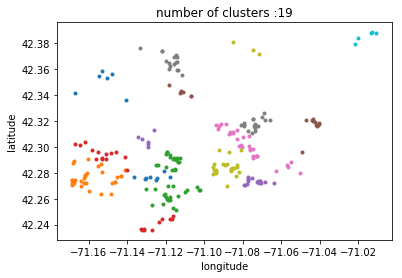

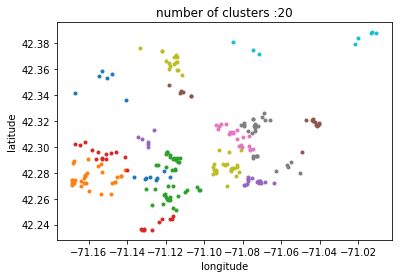

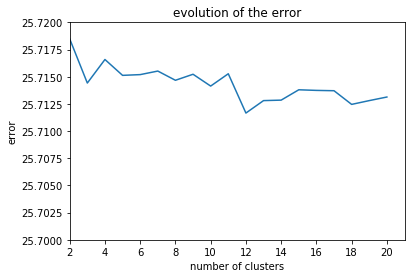

In [54]:
#Applying Kmeans with different number of clusters
km=KMeans()
dfa=df[['longitude', 'latitude']][df.a==-1]
err=[]
for j in range(2,21):
    km.n_clusters=j
    dfa['blop']=km.fit_predict(dfa)
    #e=km.score(dfa[['latitude','longitude', 'blop']])/dfa.shape[0]
    for i in dfa.blop.unique():
        plt.plot(dfa[dfa.blop==i].longitude, dfa[dfa.blop==i].latitude, '.')
    plt.title('number of clusters :{}'.format(str(j)))
    plt.ylabel('latitude')
    plt.xlabel('longitude')
    plt.show()
    if j<3:
        e=km.score(dfa[['latitude','longitude']])/dfa.shape[0]
    else:
        e=km.score(dfa[['latitude','longitude', 'blop']])/dfa.shape[0]
    err+=[-e/1000]
plt.plot(range(2,21), err)
plt.xlim(2,21)
plt.xticks(list(range(2,21,2)))
plt.ylim(25.7,25.72)
plt.title('evolution of the error')
plt.ylabel('error')
plt.xlabel('number of clusters')
plt.show()

In [55]:
#Applying Kmeans with 3 clusters as it seems the best number of clusters
km=KMeans()
km.n_clusters=3
dfa['blop']=km.fit_predict(dfa[['latitude', 'longitude']])
#merging the cluster fron DBSCAN with the one from Kmeans
df=df.merge(dfa, how='left',on=['latitude', 'longitude'])
df['cluster']= [int(a+df.a.max()+1) if b==-1 else int(b) for a, b in zip(df.blop, df.a)]
df.drop(['a', 'blop'], axis=1, inplace=True)

<a id='final'> </a>
## Clustering
<br>

   * [Mapping the accommodations](#map)
   * [DBSCAN](#DBSCAN)
   * [K Mean](#kmean)
   * **Final clustering**
   
[Top](#ToC)

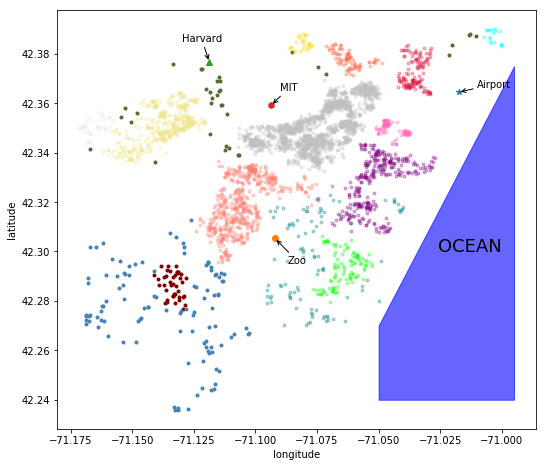

In [56]:

#plotting the different clusters together
long=df.longitude.max()-df.longitude.min()
lat=df.latitude.max()-df.latitude.min()
colist=['Salmon', 'Silver', 'Crimson','Aqua', 'Tomato', 'Gold', 'Khaki','Lavender',  'Purple', 'Lime','HotPink', 'Teal', 'DarkOliveGreen', 'SteelBlue', 'SandyBrown', 'Maroon' ]
alphas=[0.3]*12+[1]*4 #plotting the cluster from DBSCAN with some transparency as they are more dense
plt.figure(figsize=(long*50,lat*50))
for i in df.cluster.unique():
    plt.plot(df[df.cluster==i].longitude, df[df.cluster==i].latitude, '.', c=colist[int(i)-1],alpha=alphas[int(i)-1])
plt.plot(-71.017439, 42.3645004,'*')#airpot
plt.annotate( 'Airport',xy=( -71.017439, 42.3645004),xytext=(-71.01, 42.3665),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.0920313,42.3052659, 'o')#zoo
plt.annotate( 'Zoo',xy=( -71.0920313,42.3052659),xytext=(-71.087, 42.295),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.118789,42.3767973,'^') #harvard
plt.annotate( 'Harvard',xy=(-71.118789,42.3767973),xytext=(-71.13, 42.385),arrowprops=dict(arrowstyle='->'))
plt.plot(-71.0934982,42.3592003,'h')#MIT
plt.annotate( 'MIT',xy=(-71.0934982,42.3592003),xytext=(-71.09, 42.365),arrowprops=dict(arrowstyle='->'))
plt.annotate( 'OCEAN',xy=(-71.026,42.3), fontsize=18)
plt.fill_between([-71.05,-70.995],[42.27,42.375],[42.24,42.24], color='b', alpha=0.6)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

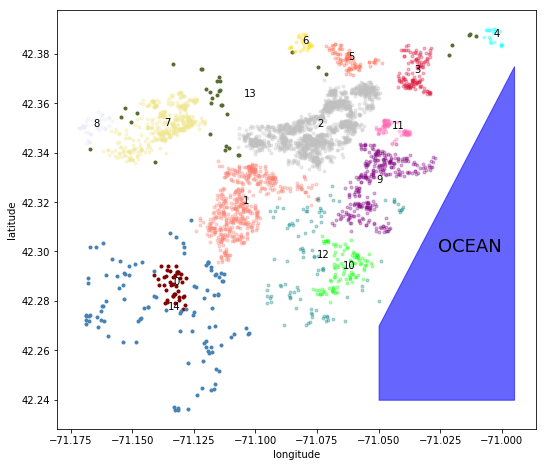

In [57]:
#plotting with the cluster number so it will be easier to identify
plt.figure(figsize=(long*50,lat*50))
for i in df.cluster.unique():
    plt.plot(df[df.cluster==i].longitude, df[df.cluster==i].latitude, '.', c=colist[int(i)-1],alpha=alphas[int(i)-1])
    plt.annotate( str(i),xy=(df[df.cluster==i].longitude.mean(), df[df.cluster==i].latitude.mean()))

plt.annotate( 'OCEAN',xy=(-71.026,42.3), fontsize=18)
plt.fill_between([-71.05,-70.995],[42.27,42.375],[42.24,42.24], color='b', alpha=0.6)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

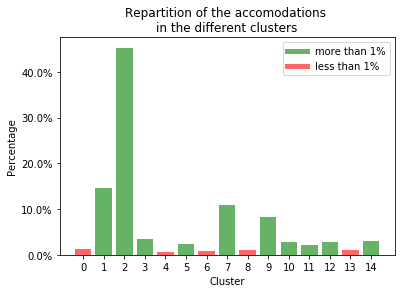

In [58]:
#checking the repartition of the accommodations in the different clusters
df_cluster=df.cluster.value_counts().sort_index()/df.shape[0]*100
colour=['red' if x<2 else 'green' for x in df_cluster ] #create a list of color for each observation
plt.bar(df_cluster.index, df_cluster, color=colour, alpha=0.6)

plt.xticks(df_cluster.index)
ylab=plt.yticks()
plt.yticks(ylab[0].tolist(), [str(s)+'%'for s in ylab[0]])
plt.ylabel('Percentage')
plt.xlabel('Cluster')
plt.title('Repartition of the accomodations \nin the different clusters')
#creating a fake legend
plt.plot('', '',c='green', label='more than 1%', linewidth=5, alpha=0.6)
plt.plot('', '',c='red', label='less than 1%', linewidth=5, alpha=0.6)
plt.legend()
plt.show()


In [59]:
#checking wich cluster correspond to which area
for i in sorted(df.cluster.unique()):
    print(i, end=':\t')
    #all the area:
    print(df[df.cluster==i].neighbourhood_cleansed.unique())
    #the most represented area in the cluster
    print(df[df.cluster==i].neighbourhood_cleansed.mode()[0])
    print('*'*20)

0:	['Roslindale' 'West Roxbury']
Roslindale
********************
1:	['Jamaica Plain' 'Mission Hill' 'Roxbury' 'Longwood Medical Area']
Jamaica Plain
********************
2:	['Longwood Medical Area' 'Bay Village' 'Leather District' 'Chinatown'
 'North End' 'Roxbury' 'South End' 'Back Bay' 'West End' 'Beacon Hill'
 'Downtown' 'Fenway']
South End
********************
3:	['East Boston']
East Boston
********************
4:	['East Boston']
East Boston
********************
5:	['Charlestown']
Charlestown
********************
6:	['Charlestown']
Charlestown
********************
7:	['Brighton' 'Allston']
Allston
********************
8:	['Brighton']
Brighton
********************
9:	['Dorchester' 'South Boston Waterfront' 'South Boston']
South Boston
********************
10:	['Dorchester']
Dorchester
********************
11:	['South Boston Waterfront']
South Boston Waterfront
********************
12:	['Roxbury' 'Mattapan' 'Dorchester']
Dorchester
********************
13:	['Longwood Medical Area' 'E

<a id='char'> </a>
## Characterization
<br>


<a id='review'> </a>

   * **Score of the reviews**
   * [Price](#price)
   * [Changes during the year](#year)
   
[Top](#ToC)

In [60]:
#list of the variables related to the review
varilist=['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',]

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
with review,37,426,1220,114,17,61,14,281,23,261,87,49,75,19,88
without review,5,100,402,12,2,21,12,106,12,36,16,24,25,17,21


review_scores_rating


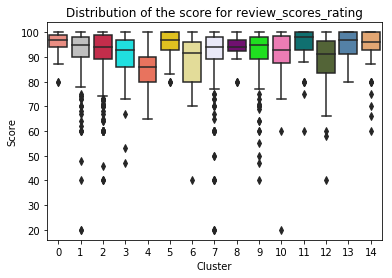

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
with review,37,422,1217,114,17,61,14,280,23,260,86,49,75,19,88
without review,5,104,405,12,2,21,12,107,12,37,17,24,25,17,21


review_scores_accuracy


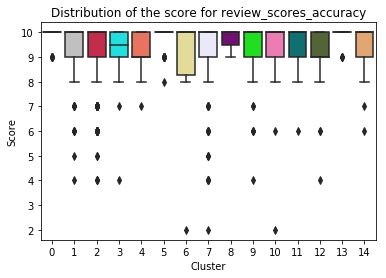

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
with review,37,426,1217,114,17,61,14,281,23,260,86,49,75,19,88
without review,5,100,405,12,2,21,12,106,12,37,17,24,25,17,21


review_scores_cleanliness


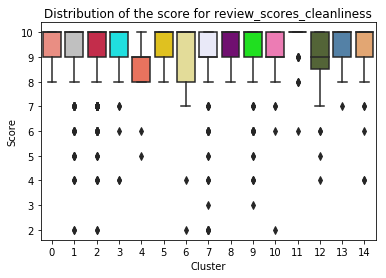

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
with review,37,424,1217,114,17,61,14,281,23,260,86,49,75,19,88
without review,5,102,405,12,2,21,12,106,12,37,17,24,25,17,21


review_scores_checkin


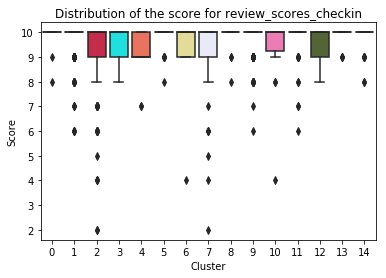

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
with review,37,425,1217,114,17,61,14,281,23,261,86,49,75,19,88
without review,5,101,405,12,2,21,12,106,12,36,17,24,25,17,21


review_scores_communication


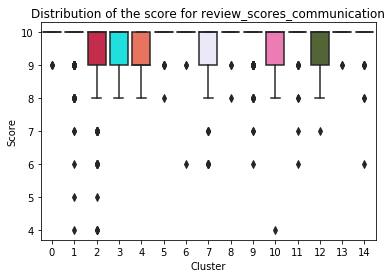

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
with review,37,423,1216,114,17,61,14,280,23,261,86,49,75,19,88
without review,5,103,406,12,2,21,12,107,12,36,17,24,25,17,21


review_scores_location


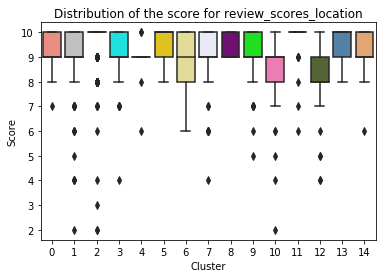

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
with review,37,423,1216,114,17,61,14,281,23,261,86,49,75,19,88
without review,5,103,406,12,2,21,12,106,12,36,17,24,25,17,21


review_scores_value


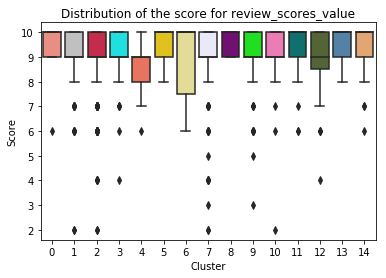

reviews_per_month


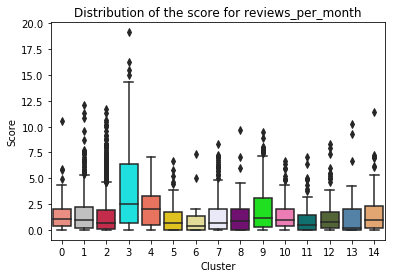

In [61]:
#plotting the score for each kind of review and each cluster
for var in varilist:
   
    sns.boxplot(x='cluster', y=var, data=df, palette =colist)
    #checking the number of score available for each cluster
    try: #As review per month doesn't have missing value
        chart=pd.crosstab(df[var].isnull(), df.cluster)
        chart.index=['with review', 'without review']
        display(chart)
    except:
        pass
    print(var)
    plt.ylabel('Score')
    plt.xlabel('Cluster')
    plt.title('Distribution of the score for {}'.format(var))
    plt.show()

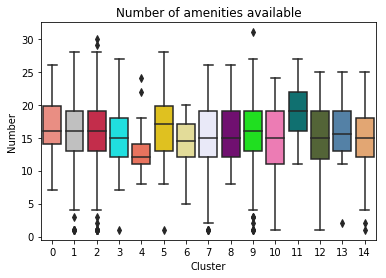

In [62]:
#plotting the number of amenities available for each cluster
sns.boxplot(x='cluster', y='num_amenities', data=df, palette =colist)
plt.title('Number of amenities available')
plt.ylabel('Number')
plt.xlabel('Cluster')
plt.show()

<a id='price'> </a>
## Characterization
<br>

   * [Score of the reviews](#review)
   * **Price**
   * [Changes during the year](#year)
   
[Top](#ToC)

In [63]:
#creating a list with the price realted variables
pricelist=['price_num',
           'price_per_bedroom',
           'price_per_bed',
           'price_per_person',
           'full_price',
           'full_price_per_person']

price_num


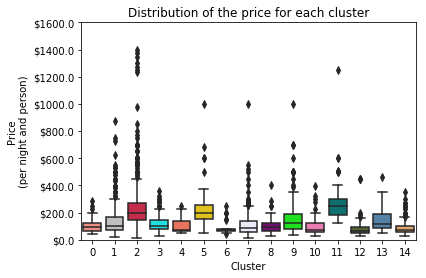

price_per_bedroom


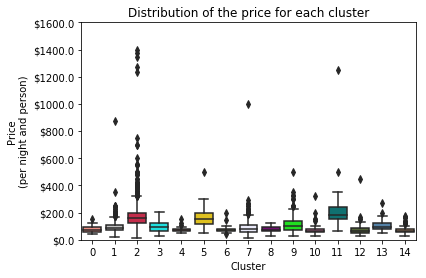

price_per_bed


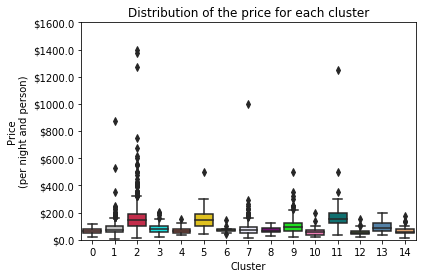

price_per_person


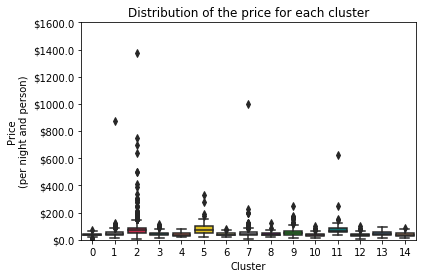

full_price


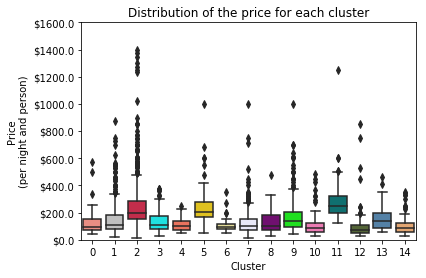

full_price_per_person


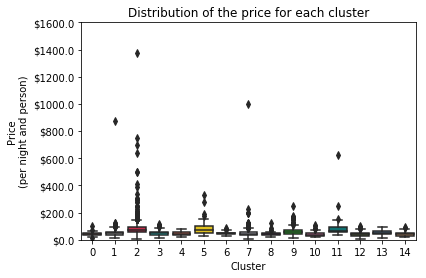

In [64]:
#plotting the different prices for each cluster
for var in pricelist:   
    sns.boxplot(x='cluster', y=var, data=df#[df[var]<200] #uncomment for the full population
                , palette =colist)


    print(var)
    plt.ylabel('Price\n(per night and person)')
    plt.xlabel('Cluster')
    plt.title('Distribution of the price for each cluster')
    tic=plt.yticks()[0]
    plt.yticks(tic, ['$'+str(x)for x in tic])
    plt.ylim(0)
    plt.show()

<a id='year'> </a>
## Characterization
<br>

   * [Score of the reviews](#review)
   * [Price](#price)
   * **Changes during the year**
   
[Top](#ToC)

In [65]:
#removing the observation with NaN as they do not have price and are irrelevant for us
df2.dropna(axis=0, inplace=True)
#converting the price into a numeric variable
df2['price_num']=[float(x[1:].replace(',',''))for x in df2.price]
#converting the date into a date variable
df2.date=pd.to_datetime(df2.date)
#the different availabilities with the cluster
df3=df2.merge(df[['id', 'cluster']], how='left', left_on='listing_id', right_on='id')

In [66]:
#aggregating the price for each day by cluster
c=df3.groupby(['cluster', 'date']).price_num.median()
c=c.reset_index()

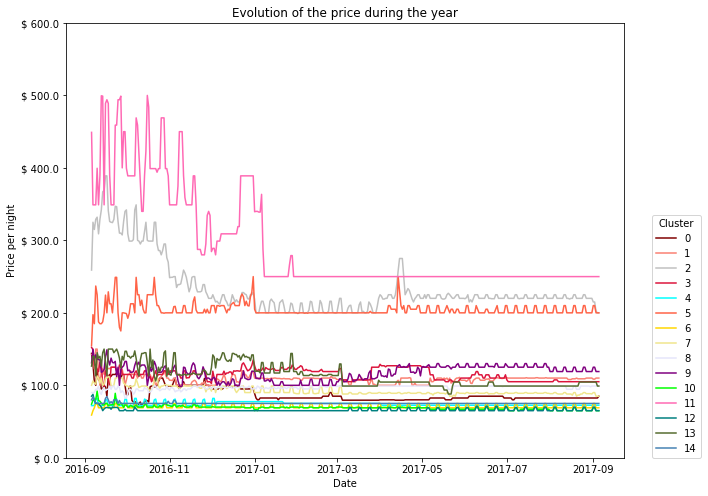

In [67]:
#plotting the time serie of the price in function of the date
plt.figure(figsize=(10,8))
for i in c.cluster.unique():
    plt.plot(c[c.cluster==i].date, c[c.cluster==i].price_num,c=colist[int(i)-1],label=str(i)[:-2])
plt.legend(title='Cluster', loc=(1.05,0))
plt.ylabel('Price per night')
tic=plt.yticks()[0]
plt.yticks(tic,['$ '+str(x) for x in tic])
plt.xlabel('Date')
plt.title('Evolution of the price during the year')
plt.show()

In [68]:
#counting the number of accommodations available each day
c=df3.groupby(['cluster', 'date']).listing_id.count()
c=c.reset_index()

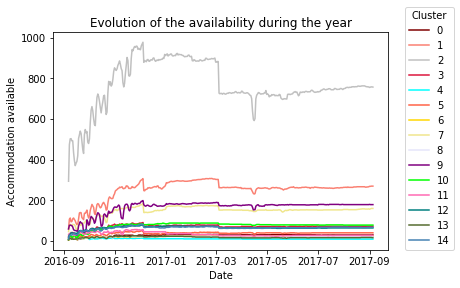

In [69]:
#plotting the number of accomodation available in function of the date for each cluster
for i in c.cluster.unique():
    plt.plot(c[c.cluster==i].date, c[c.cluster==i].listing_id,c=colist[int(i)-1],label=str(i)[:-2])
plt.legend(title='Cluster', loc=(1.05,0))
plt.ylabel('Accommodation available')
tic=plt.yticks()[0]

plt.xlabel('Date')
plt.title('Evolution of the availability during the year')
plt.show()